# Using an Echo-State Network to predict ENSO

## Preparations

In [1]:
cd("$(homedir())/Documents/enso_project.jl")
using Pkg
Pkg.activate(".")

  Activating project at `C:\Users\lihel\Documents\enso_project.jl`


In [2]:
using ReservoirComputing, CSV, DataFrames, DynamicalSystems, Plots, enso_project

┌ Warning: Circular dependency detected. Precompilation will be skipped for:
│   Base.PkgId(Base.UUID("e3ecd195-ca82-5397-9546-f380c1e34951"), "NonlinearSolveBaseSparseMatrixColoringsExt")
│   Base.PkgId(Base.UUID("385e4588-a1a0-5c1d-98fa-d45bf6f8ecf9"), "LinearSolveKernelAbstractionsExt")
│   Base.PkgId(Base.UUID("3bcf3b12-2128-5d18-8b3b-bcdd6f83637b"), "WeightInitializersGPUArraysExt")
│   Base.PkgId(Base.UUID("b00db79b-61e3-50fb-b26f-2d35b2d9e4ed"), "DiffEqBaseChainRulesCoreExt")
│   Base.PkgId(Base.UUID("8913a72c-1f9b-4ce2-8d82-65094dcecaec"), "NonlinearSolve")
│   Base.PkgId(Base.UUID("7edab7de-1038-5e4f-97a7-6bfc75d44324"), "NonlinearSolveQuasiNewtonForwardDiffExt")
│   Base.PkgId(Base.UUID("1dea7af3-3e70-54e6-95c3-0bf5283fa5ed"), "OrdinaryDiffEq")
│   Base.PkgId(Base.UUID("0d7ed370-da01-4f52-bd93-41d350b8b718"), "StaticArrayInterface")
│   Base.PkgId(Base.UUID("693f0f32-89f9-59b4-b981-3d79b82ef24b"), "SparseDiffToolsEnzymeExt")
│   Base.PkgId(Base.UUID("63d416d0-6995-5965-81e0-5

In [3]:
# read and format input data for all splits
splits = [20,40,50,60,70,80]
data = Dict()

for s in splits

    # set dict keys
    key_train = "train_data_$s"
    key_test = "test_data_$s"
    key_val = "val_data_$s"

    # read input data
    data[key_train] = CSV.read("data/sst_34_data_split_$s/train_sst_34_anomaly_embedded_$s.txt", DataFrame; delim=',', ignorerepeated=true)
    data[key_test] = CSV.read("data/sst_34_data_split_$s/test_sst_34_anomaly_embedded_$s.txt", DataFrame; delim=',', ignorerepeated=true)
    data[key_val] = CSV.read("data/sst_34_data_split_$s/val_sst_34_anomaly_embedded_$s.txt", DataFrame; delim=',', ignorerepeated=true)
   
    # bring into correct format
    data[key_train] = Matrix(transpose(Matrix(data[key_train])))
    data[key_test] = Matrix(transpose(Matrix(data[key_test])))
    data[key_val] = Matrix(transpose(Matrix(data[key_val])))
end

data

Dict{Any, Any} with 18 entries:
  "val_data_60"   => [0.53 0.65 … 0.86 0.9; -0.08 -0.1 … 0.75 0.6; … ; -0.94 -0…
  "val_data_20"   => [-0.06 0.04 … 0.86 0.9; 0.18 -0.09 … 0.75 0.6; … ; 0.64 0.…
  "train_data_70" => [0.08 -0.2 … -1.21 -1.31; 0.27 0.86 … -1.19 -0.83; … ; -0.…
  "test_data_40"  => [0.67 0.71 … -0.84 -0.69; 0.42 0.15 … 0.88 1.07; … ; -0.14…
  "test_data_20"  => [0.67 0.71 … -0.84 -0.69; 0.42 0.15 … 0.88 1.07; … ; -0.14…
  "train_data_80" => [0.08 -0.2 … 0.43 0.75; 0.27 0.86 … 0.82 0.83; … ; -0.33 -…
  "test_data_80"  => [0.67 0.71 … -0.84 -0.69; 0.42 0.15 … 0.88 1.07; … ; -0.14…
  "test_data_50"  => [0.67 0.71 … -0.84 -0.69; 0.42 0.15 … 0.88 1.07; … ; -0.14…
  "val_data_50"   => [0.66 0.85 … 0.86 0.9; 0.65 0.5 … 0.75 0.6; … ; 0.16 -0.18…
  "train_data_20" => [0.08 -0.2 … 0.01 -0.18; 0.27 0.86 … 0.09 -0.03; … ; -0.33…
  "val_data_70"   => [-1.41 -1.44 … 0.86 0.9; -0.76 -0.39 … 0.75 0.6; … ; -0.51…
  "test_data_70"  => [0.67 0.71 … -0.84 -0.69; 0.42 0.15 … 0.88 1.07; … ; -0.

## Network Training on Different Data Splits
We train the network in the same manner for six different data splits. For each data split, we try our a set of different hyperparameters.

### Hyperparameter Tuning
For each data split, we choose suitable hyperparameters by performing a grid search.


We create the hyperparameter grid as follows:
- We observe that too big reservoir sizes cause singular matrices in the linear regression (due to too little training data), thus we adapt the reservoir size to be adequately small compared to the amount of training data. This means, that the reserovir sizes are changed in each data split.
- to ensure the Echo State Property the spectral radius should be smaller than 1 (unless long memory is required). We try out different combinations.
- a sparsity of 0.1 is usually recommended, we test different values around 0.1
- a input scale of 0.1 is recommended by the literature
- we try ridge params as suggested in the lecture

In [4]:
# set up universal parameter options of parameter grid
spectral_radii = [0.8, 0.9, 1.0]
sparsities = [0.05, 0.08, 0.1, 0.12, 0.14]
input_scales = [0.1]
ridge_values = [0.0, 1e-6, 1e-5]

3-element Vector{Float64}:
 0.0
 1.0e-6
 1.0e-5

We want to store the predictions of the different data split for later purposes:

In [5]:
predictions_of_data_splits = zeros(6, size(data["test_data_20"], 2))

6×49 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

### Training Data Split 20%

train = 20%,
val =  70%,
test = 10%

We see that smaller reservoir sizes around 10 are favoured and adapt the parameter grid accordingly.

In [6]:
# set reservoir sizes according to amount of training data
reservoir_sizes = [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 30, 40]

param_grid_20 = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)

length(param_grid_20)

675

In [7]:
# network training
esn_20, W_out_20 = enso_project.cross_validate_esn(data["train_data_20"], data["val_data_20"], param_grid_20)

enso_project.ESNHyperparams(20, 0.8, 0.05, 0.1, 0.0)
Validation loss = 2577.319102762816
enso_project.ESNHyperparams(30, 0.8, 0.05, 0.1, 0.0)
Validation loss = 1717.8972700463787
enso_project.ESNHyperparams(30, 0.9, 0.05, 0.1, 0.0)
Validation loss = 1581.0695383321913
enso_project.ESNHyperparams(14, 0.8, 0.08, 0.1, 0.0)
Validation loss = 1112.5033317350203
enso_project.ESNHyperparams(18, 1.0, 0.08, 0.1, 0.0)
Validation loss = 1080.813199799742
enso_project.ESNHyperparams(12, 0.9, 0.1, 0.1, 0.0)
Validation loss = 1061.9966577489784
enso_project.ESNHyperparams(12, 0.9, 0.1, 0.1, 1.0e-6)
Validation loss = 1061.9947729193163
enso_project.ESNHyperparams(12, 0.9, 0.1, 0.1, 1.0e-5)
Validation loss = 1061.9778744921696


(ESN(5 => 12), OutputLayer successfully trained with output size: 5)

the validation loss is quite high after training.

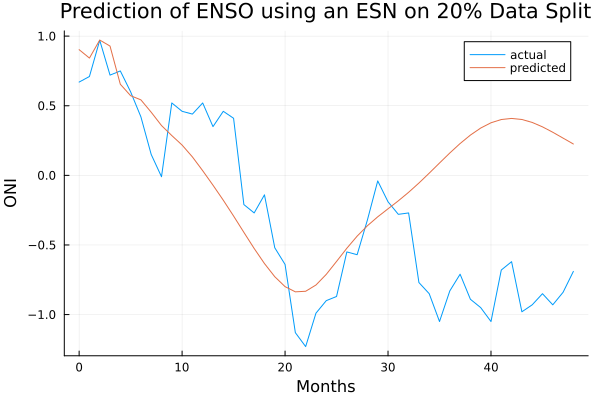

In [34]:
enso_project.plot_esn_prediction(esn_20, W_out_20, data["test_data_20"], "20% Data Split")

a visual analysis also yields that the perfomance is not good. We need more training data for a good prediction.

In [9]:
predictions_of_data_splits[1,:] = enso_project.esn_eval_pred(esn_20, W_out_20, data["test_data_20"])
predictions_of_data_splits

6×49 Matrix{Float64}:
 0.902713  0.842258  0.971677  0.928522  …  0.309522  0.267424  0.225071
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0
 0.0       0.0       0.0       0.0       …  0.0       0.0       0.0

### Training Data Split 40%

train = 40%,
val =  50%,
test = 10%

In [10]:
# set reservoir sizes according to amount of training data
reservoir_sizes = [9, 10, 12, 14, 16, 18, 20, 30, 40, 50]
param_grid_40 = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
length(param_grid_40)

450

In [11]:
# network training
esn_40, W_out_40 = enso_project.cross_validate_esn(data["train_data_40"], data["val_data_40"], param_grid_40)

enso_project.ESNHyperparams(20, 0.8, 0.05, 0.1, 0.0)
Validation loss = 692726.0482458917
enso_project.ESNHyperparams(30, 0.8, 0.05, 0.1, 0.0)
Validation loss = 1275.1205685092123
enso_project.ESNHyperparams(30, 0.9, 0.05, 0.1, 0.0)
Validation loss = 969.2130150992325
enso_project.ESNHyperparams(18, 0.8, 0.08, 0.1, 0.0)
Validation loss = 788.3682384293188
enso_project.ESNHyperparams(10, 0.8, 0.1, 0.1, 0.0)
Validation loss = 695.712523748405
enso_project.ESNHyperparams(10, 0.8, 0.1, 0.1, 1.0e-6)
Validation loss = 695.7103013452302
enso_project.ESNHyperparams(10, 0.8, 0.1, 0.1, 1.0e-5)
Validation loss = 695.690394328299


(ESN(5 => 10), OutputLayer successfully trained with output size: 5)

the validation loss is significantly smaller than in the previous 20% split, but still high

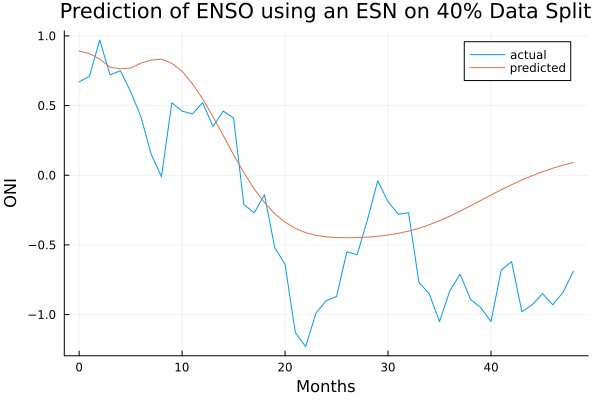

In [12]:
enso_project.plot_esn_prediction(esn_40, W_out_40, data["test_data_40"], "40% Data Split")

We see that the prediction is still not very accurate, although the dynamics are captured a bit better.

In [13]:
predictions_of_data_splits[2,:] = enso_project.esn_eval_pred(esn_40, W_out_40, data["test_data_40"])
predictions_of_data_splits

6×49 Matrix{Float64}:
 0.902713  0.842258  0.971677  0.928522  …  0.309522   0.267424   0.225071
 0.891192  0.872629  0.834434  0.774888     0.0500965  0.0721807  0.0913485
 0.0       0.0       0.0       0.0          0.0        0.0        0.0
 0.0       0.0       0.0       0.0          0.0        0.0        0.0
 0.0       0.0       0.0       0.0          0.0        0.0        0.0
 0.0       0.0       0.0       0.0       …  0.0        0.0        0.0

### Training Data Split 50%

train = 50%,
val =  40%,
test = 10%

In [14]:
# set reservoir sizes according to amount of training data
reservoir_sizes = [9, 10, 12, 14, 16, 18, 20, 30, 40, 50]
param_grid_50 = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
length(param_grid_50)

450

In [15]:
# network training
esn_50, W_out_50 = enso_project.cross_validate_esn(data["train_data_50"], data["val_data_50"], param_grid_50)

enso_project.ESNHyperparams(20, 0.8, 0.05, 0.1, 0.0)
Validation loss = 776.6603741880992
enso_project.ESNHyperparams(30, 0.8, 0.05, 0.1, 0.0)
Validation loss = 749.1956083615036
enso_project.ESNHyperparams(40, 0.8, 0.05, 0.1, 0.0)
Validation loss = 567.2550516222186
enso_project.ESNHyperparams(16, 0.8, 0.08, 0.1, 0.0)
Validation loss = 552.9199647143967
enso_project.ESNHyperparams(16, 0.8, 0.08, 0.1, 1.0e-6)
Validation loss = 552.6624648007332
enso_project.ESNHyperparams(16, 0.8, 0.08, 0.1, 1.0e-5)
Validation loss = 551.2814053153184


(ESN(5 => 16), OutputLayer successfully trained with output size: 5)

the validation loss decreased a bit.

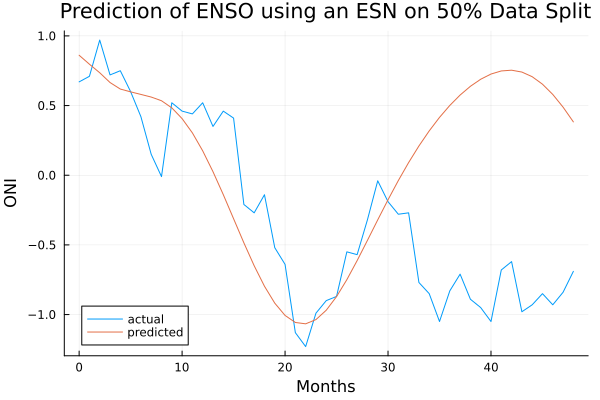

In [16]:
enso_project.plot_esn_prediction(esn_50, W_out_50, data["test_data_50"], "50% Data Split")

The prediciton captures the dynamics of the system quite well for approximately 30 months.

In [17]:
predictions_of_data_splits[3,:] = enso_project.esn_eval_pred(esn_50, W_out_50, data["test_data_50"])
predictions_of_data_splits

6×49 Matrix{Float64}:
 0.902713  0.842258  0.971677  0.928522  …  0.309522   0.267424   0.225071
 0.891192  0.872629  0.834434  0.774888     0.0500965  0.0721807  0.0913485
 0.86101   0.796674  0.735449  0.665316     0.579793   0.488599   0.382677
 0.0       0.0       0.0       0.0          0.0        0.0        0.0
 0.0       0.0       0.0       0.0          0.0        0.0        0.0
 0.0       0.0       0.0       0.0       …  0.0        0.0        0.0

### Training Data Split 60%

train = 60%,
val =  30%,
test = 10%

In [18]:
# set reservoir sizes according to amount of training data
reservoir_sizes = [10, 14, 15, 18, 20, 22, 24, 26, 28, 30, 35, 40, 50]
param_grid_60 = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
length(param_grid_60)

585

In [19]:
# network training
esn_60, W_out_60 = enso_project.cross_validate_esn(data["train_data_60"], data["val_data_60"], param_grid_60)

enso_project.ESNHyperparams(20, 0.8, 0.05, 0.1, 0.0)
Validation loss = 820.9585588714748
enso_project.ESNHyperparams(22, 0.8, 0.05, 0.1, 0.0)
Validation loss = 463.5949510414701
enso_project.ESNHyperparams(22, 0.9, 0.05, 0.1, 0.0)
Validation loss = 451.5434037851952
enso_project.ESNHyperparams(30, 0.8, 0.08, 0.1, 0.0)
Validation loss = 411.1209982117105
enso_project.ESNHyperparams(24, 0.8, 0.1, 0.1, 0.0)
Validation loss = 408.6913209440175
enso_project.ESNHyperparams(24, 0.9, 0.1, 0.1, 0.0)
Validation loss = 367.89701551002815
enso_project.ESNHyperparams(24, 1.0, 0.1, 0.1, 0.0)
Validation loss = 347.57056225229434


(ESN(5 => 24), OutputLayer successfully trained with output size: 5)

The more data is used for training, the more the validation loss decreases

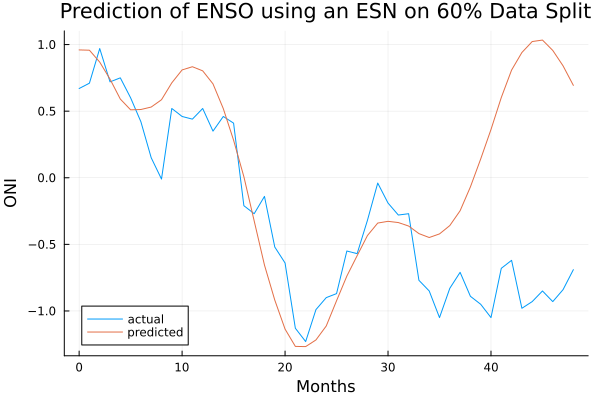

In [20]:
enso_project.plot_esn_prediction(esn_60, W_out_60, data["test_data_60"], "60% Data Split")

The predicitons for the first 30 months get more accurate.

In [21]:
predictions_of_data_splits[4,:] = enso_project.esn_eval_pred(esn_60, W_out_60, data["test_data_60"])
predictions_of_data_splits

6×49 Matrix{Float64}:
 0.902713  0.842258  0.971677  0.928522  …  0.309522   0.267424   0.225071
 0.891192  0.872629  0.834434  0.774888     0.0500965  0.0721807  0.0913485
 0.86101   0.796674  0.735449  0.665316     0.579793   0.488599   0.382677
 0.959642  0.957428  0.868194  0.740188     0.955785   0.839977   0.693343
 0.0       0.0       0.0       0.0          0.0        0.0        0.0
 0.0       0.0       0.0       0.0       …  0.0        0.0        0.0

### Training Data Split 70%

train = 70%,
val =  20%,
test = 10%

In [22]:
# set reservoir sizes according to amount of training data
reservoir_sizes = [ 40, 50, 60, 62, 63, 64, 65, 66, 68, 70, 72, 74, 80, 90]
param_grid_70 = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
length(param_grid_70)

630

In [23]:
# network training
esn_70, W_out_70 = enso_project.cross_validate_esn(data["train_data_70"], data["val_data_70"], param_grid_70)

enso_project.ESNHyperparams(40, 0.8, 0.05, 0.1, 0.0)
Validation loss = 321.3044907265264
enso_project.ESNHyperparams(65, 0.8, 0.05, 0.1, 0.0)
Validation loss = 315.8844810655485
enso_project.ESNHyperparams(72, 0.8, 0.05, 0.1, 0.0)
Validation loss = 278.20808744813075
enso_project.ESNHyperparams(74, 0.8, 0.05, 0.1, 0.0)
Validation loss = 243.28631957265637
enso_project.ESNHyperparams(68, 1.0, 0.05, 0.1, 0.0)
Validation loss = 237.9010746466473
enso_project.ESNHyperparams(64, 1.0, 0.1, 0.1, 0.0)
Validation loss = 191.44796199449564
enso_project.ESNHyperparams(64, 1.0, 0.1, 0.1, 1.0e-6)
Validation loss = 191.4459159607499
enso_project.ESNHyperparams(64, 1.0, 0.1, 0.1, 1.0e-5)
Validation loss = 191.4140311460462


(ESN(5 => 64), OutputLayer successfully trained with output size: 5)

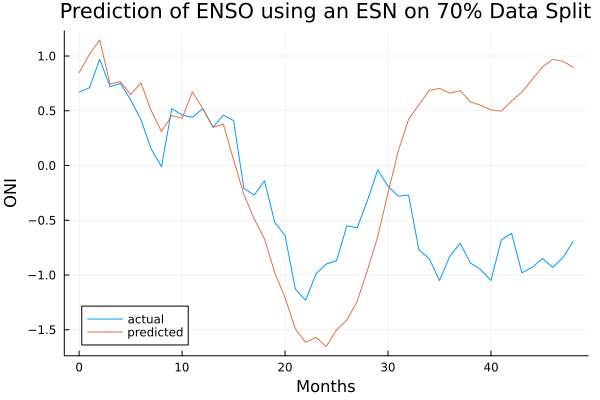

In [24]:
enso_project.plot_esn_prediction(esn_70, W_out_70, data["test_data_70"], "70% Data Split")

In [25]:
predictions_of_data_splits[5,:] = enso_project.esn_eval_pred(esn_70, W_out_70, data["test_data_70"])
predictions_of_data_splits

6×49 Matrix{Float64}:
 0.902713  0.842258  0.971677  0.928522  …  0.309522   0.267424   0.225071
 0.891192  0.872629  0.834434  0.774888     0.0500965  0.0721807  0.0913485
 0.86101   0.796674  0.735449  0.665316     0.579793   0.488599   0.382677
 0.959642  0.957428  0.868194  0.740188     0.955785   0.839977   0.693343
 0.848469  1.01469   1.14567   0.743075     0.969637   0.952005   0.895629
 0.0       0.0       0.0       0.0       …  0.0        0.0        0.0

### Training Data Split 80%

train = 80%,
val =  10%,
test = 10%

In [26]:
# set reservoir sizes according to amount of training data
reservoir_sizes = [60, 70, 80, 90, 100, 110, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 150]
param_grid_80 = enso_project.create_param_grid(reservoir_sizes, spectral_radii, sparsities, input_scales, ridge_values)
length(param_grid_80)

810

In [27]:
# network training
esn_80, W_out_80 = enso_project.cross_validate_esn(data["train_data_80"], data["val_data_80"], param_grid_80)

enso_project.ESNHyperparams(60, 0.8, 0.05, 0.1, 0.0)
Validation loss = 127.16642736581892
enso_project.ESNHyperparams(80, 0.8, 0.05, 0.1, 0.0)
Validation loss = 86.7336725165429
enso_project.ESNHyperparams(80, 0.9, 0.05, 0.1, 0.0)
Validation loss = 83.0308743245183
enso_project.ESNHyperparams(122, 0.9, 0.05, 0.1, 0.0)
Validation loss = 66.9215145530872
enso_project.ESNHyperparams(134, 0.8, 0.08, 0.1, 0.0)
Validation loss = 61.8416287894251
enso_project.ESNHyperparams(70, 1.0, 0.08, 0.1, 0.0)
Validation loss = 60.98980360235752
enso_project.ESNHyperparams(80, 0.8, 0.1, 0.1, 0.0)
Validation loss = 58.51413076648854
enso_project.ESNHyperparams(60, 0.9, 0.1, 0.1, 0.0)
Validation loss = 51.23956157443753
enso_project.ESNHyperparams(70, 1.0, 0.1, 0.1, 0.0)
Validation loss = 39.71078521562258
enso_project.ESNHyperparams(130, 0.9, 0.14, 0.1, 0.0)
Validation loss = 30.50979942909385
enso_project.ESNHyperparams(130, 0.9, 0.14, 0.1, 1.0e-6)
Validation loss = 30.49596650913812
enso_project.ESNHype

(ESN(5 => 130), OutputLayer successfully trained with output size: 5)

very low validation loss for following set of hyperparameters: $(130,0.9,0.14,0.1,1.0e-5)$

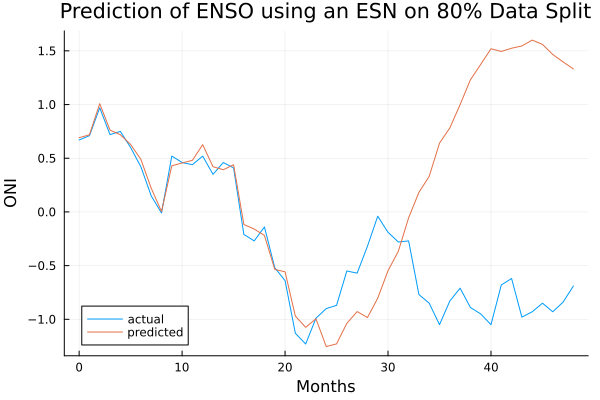

In [28]:
enso_project.plot_esn_prediction(esn_80, W_out_80, data["test_data_80"], "80% Data Split")

very accurate prediction for up to 20 months.

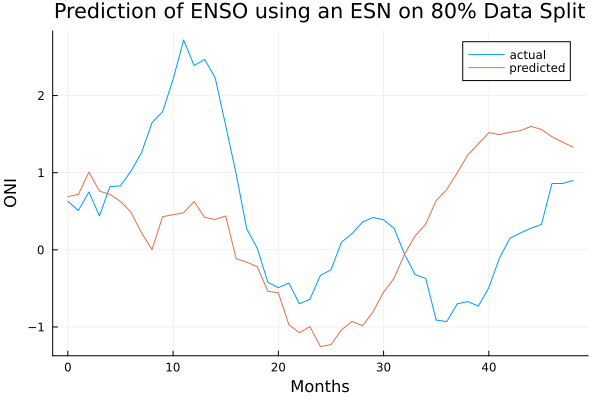

In [29]:
# plot against validation data
enso_project.plot_esn_prediction(esn_80, W_out_80, data["val_data_80"], "80% Data Split")

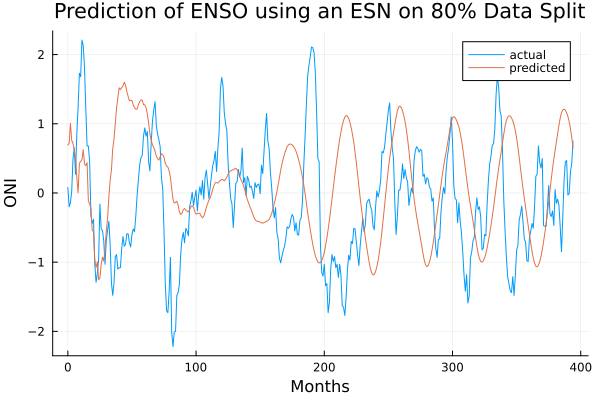

In [30]:
# plot against training data
enso_project.plot_esn_prediction(esn_80, W_out_80, data["train_data_80"], "80% Data Split")

In [31]:
predictions_of_data_splits[6,:] = enso_project.esn_eval_pred(esn_80, W_out_80, data["test_data_80"])
predictions_of_data_splits

6×49 Matrix{Float64}:
 0.902713  0.842258  0.971677  0.928522  …  0.309522   0.267424   0.225071
 0.891192  0.872629  0.834434  0.774888     0.0500965  0.0721807  0.0913485
 0.86101   0.796674  0.735449  0.665316     0.579793   0.488599   0.382677
 0.959642  0.957428  0.868194  0.740188     0.955785   0.839977   0.693343
 0.848469  1.01469   1.14567   0.743075     0.969637   0.952005   0.895629
 0.69168   0.718218  1.00798   0.761898  …  1.46605    1.39684    1.33177

## Comparison of Data Splits

For better comparison we plot all test set predictions in one Figure.

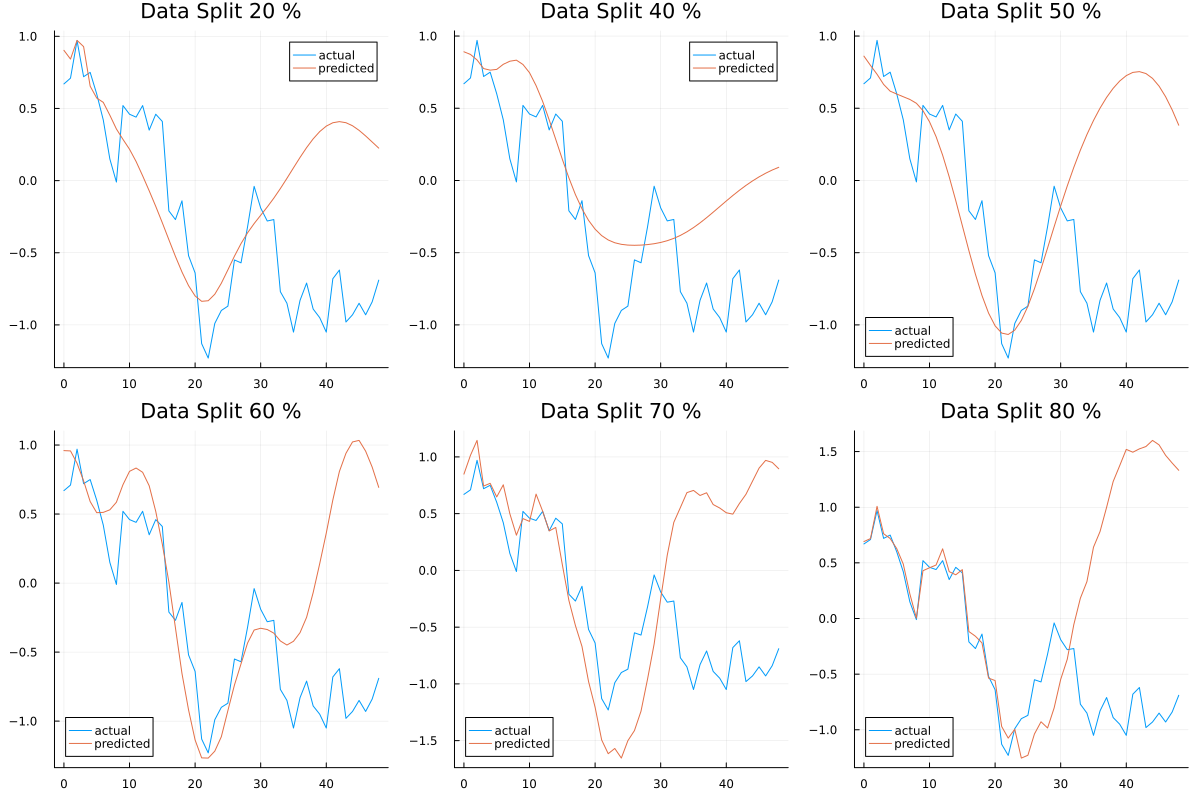

In [32]:
enso_project.plot_data_split_predictions(predictions_of_data_splits, data["test_data_80"], splits)

TODO:
- store all 6 test losses in an array and line-plot

## Evaluation of Prediction Accuracy

TODO